# Fiat Trading Calculator

When we buy and sell cryptocurrencies other than those currently exchanged for fiat currencies (e.g. USD or Euro or some other money). I wanted to know which of these Fiat exchanged currencies where the most stable and generally tended to increase in value with respect to time.

***WARNING This is not financial advice - Use good judgement and common sense. This is just a simple application of mathematics nothing more***

In [1]:
# data analysis
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats

# import libraries for reading JSON
import json
import requests
from pandas.io.json import json_normalize

# data persistence use this to prevent from creating mutliple calls to APIs unnecessarily
# WARNING - When you run this initially the pickle file will be created. and stored to the folder with your Notebook
# Make sure you remove the pickle files before you do new analysis
import pickle

# external data we will use for BTC values from multiple exchanges.
import quandl

# data visualization
from ipywidgets import interact

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure

import matplotlib.pyplot as plt
%matplotlib inline #allows the plots to show up inline with the code (you won't see the memory address)

UsageError: unrecognized arguments: #allows the plots to show up inline with the code (you won't see the memory address)


These are helper functions I am creating to use later on in our analysis

In [2]:
#just a generic function to get json data into a dataframe
def api_to_dataframe (url):
    '''Pull JSON into a dataframe'''
    input_url = requests.get(url)
    parse_json = input_url.json()
    json_df_output = json_normalize(parse_json)
    return json_df_output

In [3]:
#This is a helper function for quandls API https://blog.quandl.com/api-for-bitcoin-data
#quandl provides us with bitcoin data we will use to create an index
def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries'''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

In [4]:
#not digging on how this was done
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

In [5]:
#this is a function to download and cache JSON data from a provided URL
def get_json_data(json_url, cache_path):
    '''Download and cache JSON data, return as a dataframe.'''
    try:        
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(json_url))
    except (OSError, IOError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
    return df

In [6]:
def get_crypto_data(poloniex_pair):
    '''Retrieve cryptocurrency data from poloniex'''
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), pediod)
    data_df = get_json_data(json_url, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

# BTC Index

In [7]:
exchanges = ['COINBASE','BITSTAMP','ITBIT','KRAKEN'] #list of exchanges I want to pull data from

exchange_data = {}

for exchange in exchanges:
    exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = get_quandl_data(exchange_code)
    exchange_data[exchange] = btc_exchange_df

# Let me explain this to myself
# This is creating a series of all list values for each key then creating a Weighted Price column
btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Weighted Price')

# Remove "0" values
btc_usd_datasets.replace(0, np.nan, inplace=True)
btc_usd_datasets['avg_btc_price_usd'] = btc_usd_datasets.mean(axis=1)

#do you see the expected results
btc_usd_datasets.tail()

Loaded BCHARTS/COINBASEUSD from cache
Loaded BCHARTS/BITSTAMPUSD from cache
Loaded BCHARTS/ITBITUSD from cache
Loaded BCHARTS/KRAKENUSD from cache


,BITSTAMP,COINBASE,ITBIT,KRAKEN,avg_btc_price_usd
Date,,,,,
2018-01-27,11287.971181,NaN,11270.754236,11278.723194,11279.149537
2018-01-28,11704.543985,NaN,11651.019684,11619.862774,11658.475481
2018-01-29,11284.764330,NaN,11206.107730,11260.031164,11250.301075
2018-01-30,10395.940369,NaN,10391.521109,10360.196880,10382.552786
2018-01-31,9937.787158,NaN,9983.222933,9925.052271,9948.687454


# Get Exchange Rates

In [8]:
cbase_exchange = 'https://api.coinbase.com/v2/exchange-rates'
gdax_products = 'https://api.gdax.com/products'

df = api_to_dataframe(gdax_products)
crypto_to_fiat = df[df['quote_currency'] == 'USD'] #filtering out USD only

df = api_to_dataframe(cbase_exchange)
dft = df.transpose().reset_index() #putting this into a format I want
dft.columns=['currencey','exchange_rate'] #change column names

#looks like this is a USD only exchange ATM retest if that changes
dft = dft[dft['exchange_rate'] != 'USD'] # Filtering out junk data. Though you may need to test this assumption in the future

#get rid of the data.rates string from cbase stuff
dft['currencey'] = dft['currencey'].map(lambda x: x.replace('data.rates.','')) 

dft[dft.currencey.isin(crypto_to_fiat['base_currency'])]

crypto_x_usd = dft[dft.currencey.isin(crypto_to_fiat['base_currency'])]

crypto_x_usd.set_index('currencey',inplace=True)

crypto_x_usd['exchange_rate'] = pd.to_numeric(crypto_x_usd['exchange_rate']) #was a string originally (casting and apply did not work)
crypto_x_usd['dollar_value'] = 1/crypto_x_usd['exchange_rate']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Convert Fiat to USD over time with BTC Index

In [9]:
base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2017-11-01', '%Y-%m-%d') # get data from the start of 2015
end_date = datetime.now() # up until today
pediod = 86400 # pull daily data (86,400 seconds per day)

In [10]:
crypto_to_fiat[crypto_to_fiat['base_currency'] != 'BTC']['base_currency'].tolist()

['BCH', 'ETH', 'LTC']

In [11]:
coins = crypto_to_fiat[crypto_to_fiat['base_currency'] != 'BTC']['base_currency'].tolist()

coin_data = {}
for coin in coins:
    coinpair = 'BTC_{}'.format(coin)
    crypto_price_df = get_crypto_data(coinpair)
    coin_data[coin] = crypto_price_df

# Calculate USD Price as a new column in each altcoin dataframe
for coin in coin_data.keys():
    coin_data[coin]['price_usd'] =  coin_data[coin]['weightedAverage'] * btc_usd_datasets['avg_btc_price_usd']

# Calculate rate of return
for coin in coin_data.keys():
    coin_data[coin]['returns'] = np.log(1 + coin_data[coin]['price_usd'].pct_change())

#cumulative returns
for coin in coin_data.keys():
    coin_data[coin]['cumulative_return'] = coin_data[coin]['price_usd']/coin_data[coin]['price_usd'].iloc[0]


Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_BCH&start=1509519600.0&end=1523146505.552428&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETH&start=1509519600.0&end=1523146505.552428&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_LTC&start=1509519600.0&end=1523146505.552428&period=86400 from cache


In [12]:
# Calculate rate of return
btc_usd_datasets['returns'] = np.log(1 + btc_usd_datasets['avg_btc_price_usd'].pct_change())

#cumulative returns
btc_usd_datasets['cumulative_return'] = btc_usd_datasets['avg_btc_price_usd']/btc_usd_datasets['avg_btc_price_usd'].iloc[0]
btc_usd_datasets.tail()

,BITSTAMP,COINBASE,ITBIT,KRAKEN,avg_btc_price_usd,returns,cumulative_return
Date,,,,,,,
2018-01-27,11287.971181,NaN,11270.754236,11278.723194,11279.149537,0.033577,1902.295628
2018-01-28,11704.543985,NaN,11651.019684,11619.862774,11658.475481,0.033078,1966.271203
2018-01-29,11284.764330,NaN,11206.107730,11260.031164,11250.301075,-0.035639,1897.430163
2018-01-30,10395.940369,NaN,10391.521109,10360.196880,10382.552786,-0.080268,1751.079255
2018-01-31,9937.787158,NaN,9983.222933,9925.052271,9948.687454,-0.042686,1677.905287


# Combined DF

In [13]:
# Merge USD price of each altcoin into single dataframe 
combined_df = merge_dfs_on_column(list(coin_data.values()), list(coin_data.keys()), 'price_usd')

# Add BTC price to the dataframe
combined_df['BTC'] = btc_usd_datasets['avg_btc_price_usd']

#combined_df.tail()
coin_data['BCH'].tail()

,close,high,low,open,quoteVolume,volume,weightedAverage,price_usd,returns,cumulative_return
date,,,,,,,,,,
2018-01-28,0.148640,0.149849,0.142160,0.143017,3750.048633,546.573047,0.145751,1699.233527,0.048150,3.111356
2018-01-29,0.147193,0.150339,0.146291,0.149577,2021.259629,299.385783,0.148118,1666.376820,-0.019526,3.051194
2018-01-30,0.144840,0.151700,0.143110,0.146765,5486.478208,811.991982,0.147999,1536.604938,-0.081076,2.813577
2018-01-31,0.145676,0.148945,0.143500,0.145139,2696.311445,394.095790,0.146161,1454.110803,-0.055181,2.662528
2018-02-01,0.145550,0.147000,0.145350,0.145676,436.966267,63.778750,0.145958,NaN,NaN,NaN


# btc_x_df

In [14]:
btc_x_df = merge_dfs_on_column(list(coin_data.values()), list(coin_data.keys()), 'close')

btc_x_df.tail()

,BCH,ETH,LTC
date,,,
2018-01-28,0.148640,0.105169,0.016540
2018-01-29,0.147193,0.104871,0.016154
2018-01-30,0.144840,0.105726,0.016456
2018-01-31,0.145676,0.109499,0.016050
2018-02-01,0.145550,0.112780,0.016162


# Returns DF

In [15]:
# Merge USD price of each altcoin into single dataframe 
returns_df = merge_dfs_on_column(list(coin_data.values()), list(coin_data.keys()), 'returns')

# Add BTC price to the dataframe
returns_df['BTC'] = btc_usd_datasets['returns']

#check
returns_df.tail()

,BCH,ETH,LTC,BTC
date,,,,
2018-01-28,0.048150,0.099086,0.047962,0.033078
2018-01-29,-0.019526,-0.014707,-0.032629,-0.035639
2018-01-30,-0.081076,-0.065901,-0.073746,-0.080268
2018-01-31,-0.055181,-0.021276,-0.052454,-0.042686
2018-02-01,NaN,NaN,NaN,NaN


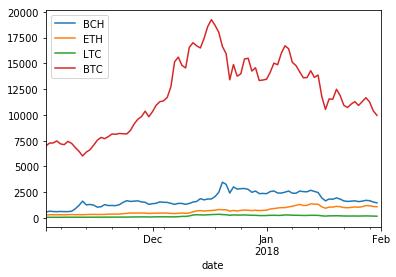

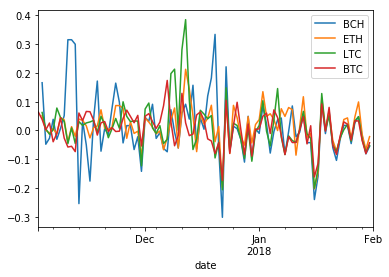

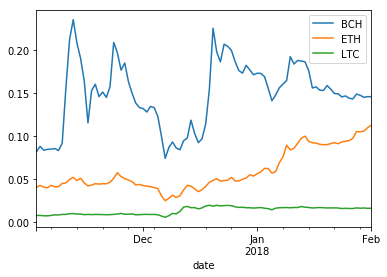

In [16]:
combined_df.plot()
returns_df.plot()
btc_x_df.plot()

plt.show()

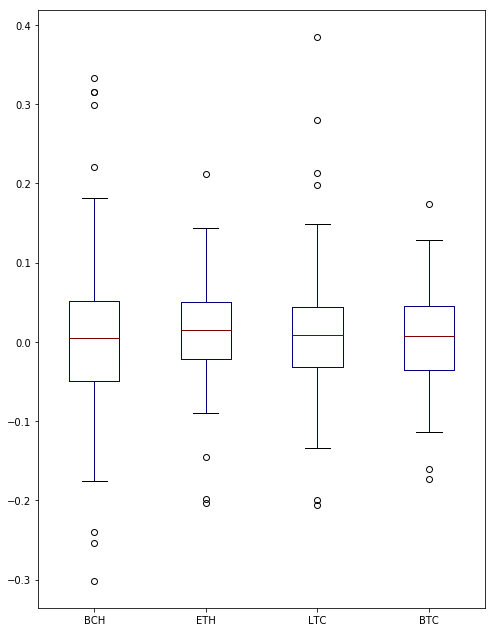

In [17]:
returns_df.plot(kind='box',figsize=(8,11),colormap='jet')
plt.show()

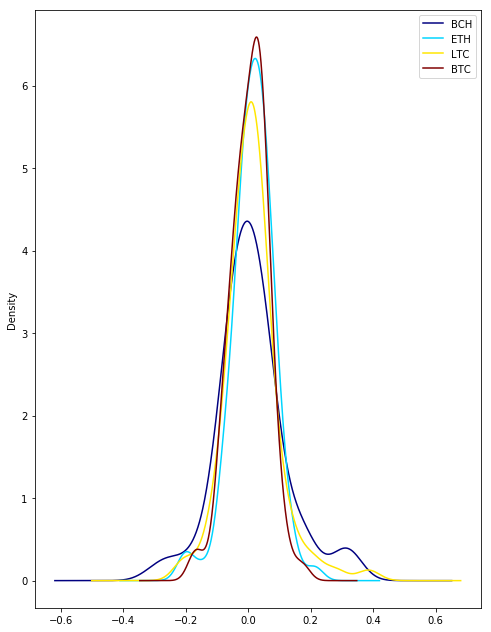

In [18]:
#scrub returns and drop gah-big
returns_november_td = returns_df['11-01-2017':].dropna()

#(returns_november_td / returns_november_td.iloc[0]*100).plot(kind='kde',figsize=(8,11),colormap='jet')
returns_november_td.plot(kind='kde',figsize=(8,11),colormap='jet')
plt.show()

In [19]:
returns_november_td.cov()

,BCH,ETH,LTC,BTC
BCH,0.012285,0.003535,0.003361,0.001059
ETH,0.003535,0.004379,0.004170,0.002014
LTC,0.003361,0.004170,0.007377,0.003089
BTC,0.001059,0.002014,0.003089,0.003536


In [20]:
returns_november_td.var()

BCH    0.012285
ETH    0.004379
LTC    0.007377
BTC    0.003536
dtype: float64

In [21]:
returns_november_td.std()

BCH    0.110838
ETH    0.066173
LTC    0.085887
BTC    0.059466
dtype: float64

In [22]:
returns_november_td.corr()

,BCH,ETH,LTC,BTC
BCH,1.000000,0.481906,0.353071,0.160630
ETH,0.481906,1.000000,0.733640,0.511929
LTC,0.353071,0.733640,1.000000,0.604871
BTC,0.160630,0.511929,0.604871,1.000000


# Normalize the results

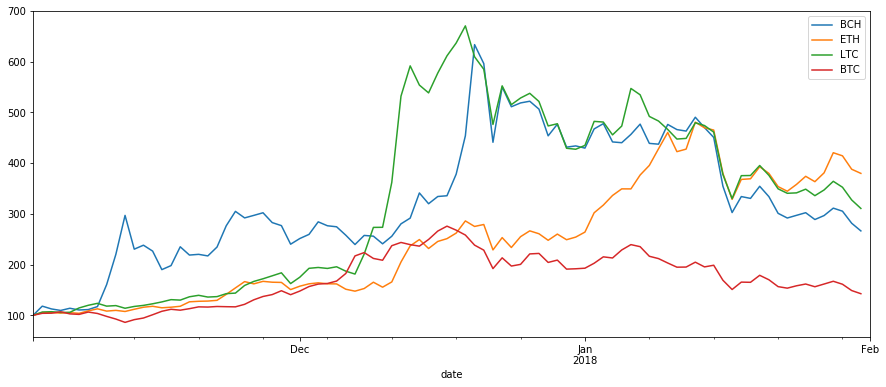

In [23]:
# Normalize the results
crypto_to_USD = combined_df['2017-11-01':] #slice df from 11/1 to date

(crypto_to_USD / crypto_to_USD.iloc[0] * 100).plot(figsize = (15, 6));
plt.show() 

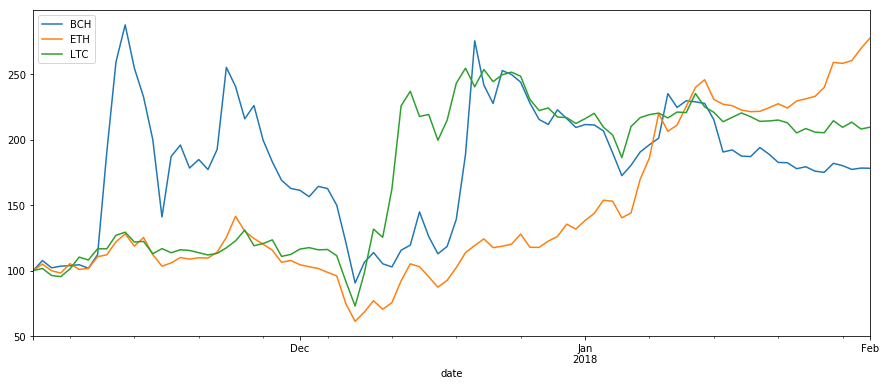

In [24]:
# Normalize the results
#I wanted to look at all the non-btc stuff, just stuff that was exchanged with BTC
btc_exchange_df = btc_x_df['2017-11-01':] #slice df from 11/1 to date

(btc_exchange_df / btc_exchange_df.iloc[0] * 100).plot(figsize = (15, 6));
plt.show() 

# Rate of return

In [25]:
#np.log(PG['Close'] / PG['Close'].shift(1))
# applymap is supposed to apply a function for an entire dataframe....I think for a simple one
#returns = combined_df.applymap(pct_change(1))
cdfkeys = crypto_to_fiat['base_currency'].tolist()

# log returns -> np.log(1 + data.pct_change()
returns = pd.DataFrame()

for cdfkey in cdfkeys:
    returns[cdfkey] = np.log(1 + combined_df[cdfkey].pct_change())

returns.dropna(inplace=True)

returns = returns['2017-11-01':]

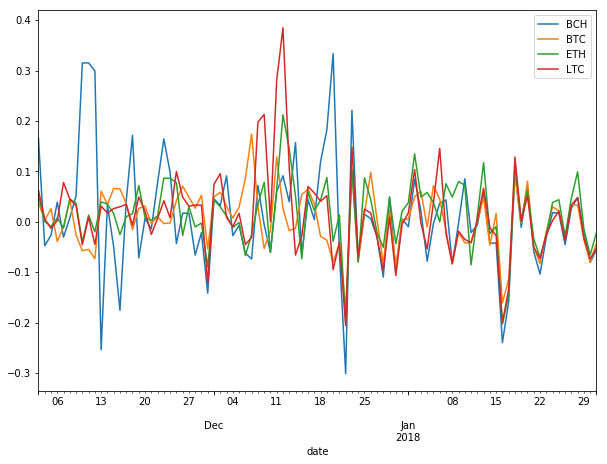

In [26]:
returns.plot(figsize = (10,7))
plt.show()

# Crypto to USD

In [27]:
crypto_x_usd

,exchange_rate,dollar_value
currencey,,
BCH,0.001556,642.863571
BTC,0.000144,6944.444444
ETH,0.002591,385.994573
LTC,0.008588,116.435039


In [28]:
from pandas.plotting import scatter_matrix
scatter_matrix(crypto_to_USD,figsize=(10,10),alpha=0.5,hist_kwds={'bins':25});